In [1]:
from xml.etree.ElementPath import xpath_tokenizer_re

from TP2.tokenizer import dataset_to_tokens, sentence_from_model_output
from datasets import load_dataset
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

dataset = load_dataset("csv", data_files="line_index_all.dataset.csv")
words = dataset['train']['X']
labels = dataset['train']['Y']

df = dataset_to_tokens(labels)
#output_df = sentence_from_model_output(df, tokenizer)
df

/home/jorge/.conda/envs/aa_dc/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,instancia_id,token_id,token,punt_inicial,punt_final,capitalización,embedding,numero_palabra
0,0,10220,para,,,1,"[[-0.022991918, -0.011615043, -0.027248334, -0...",0
1,0,10109,la,,,0,"[[-0.0065727993, -0.03248966, 0.004454881, -0....",1
2,0,56097,caída,,,0,"[[-0.003799043, -0.04359478, -0.11301553, -0.0...",2
3,0,10127,del,,,0,"[[-0.008695853, -0.0391686, -0.0030513217, -0....",3
4,0,104471,cabe,,,0,"[[-0.06647815, -0.051001675, -0.037380584, 0.0...",4
...,...,...,...,...,...,...,...,...
70965,5738,21114,##lam,,,0,"[[0.029697862, -0.038755476, 0.04934575, 0.012...",1
70966,5738,10310,##os,,,0,"[[0.029697862, -0.038755476, 0.04934575, 0.012...",1
70967,5738,169,a,,,0,"[[-0.007851623, -0.039989512, 0.030766966, -0....",2
70968,5738,10109,la,,,0,"[[-0.0065727993, -0.03248966, 0.004454881, -0....",3


In [2]:
from sklearn.model_selection import train_test_split
import numpy as np

word_embeddings = []
initial_capitalization = []
for id_instancia, instancia_df in df.groupby(df.columns[0], sort=False): # instancia_id column
    for numero_palabra, instancia_una_palabra_df in instancia_df.groupby(instancia_df.columns[-1], sort=False): # numero_palabra column
        embeddings = np.concat(instancia_df['embedding'].to_list(), axis=0)
        mean_embedding = np.mean(embeddings, axis=0)
        word_embeddings.append(mean_embedding)
        initial_capitalization.append(instancia_una_palabra_df['punt_inicial'].iloc[0])
        #TODO: acá puedo agregar la columna pred mientras evalúo el modelo?? O me guardo el iloc del dataframe y después lo uso para asignar las predicciones?

X_train, X_test, y_train, y_test = train_test_split(word_embeddings, initial_capitalization, test_size=0.35, random_state=420)
X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [3]:
X_train

array([[-0.00025643, -0.04573169,  0.00662334, ..., -0.00945024,
        -0.01943852, -0.00933067],
       [ 0.01382076, -0.02957218, -0.00376122, ..., -0.00829961,
         0.00990593, -0.00296044],
       [-0.00732321, -0.02046166,  0.02559587, ...,  0.00233471,
         0.00900261, -0.02590339],
       ...,
       [-0.00144508, -0.0356864 , -0.01146241, ..., -0.01176957,
        -0.00099764, -0.02201654],
       [-0.00114104, -0.02747251, -0.01449578, ..., -0.00066097,
        -0.00475032,  0.00061153],
       [ 0.00702325, -0.02254833, -0.00757059, ..., -0.03837785,
        -0.01415703, -0.00229506]], shape=(33978, 768), dtype=float32)

In [4]:
from sklearn.ensemble import RandomForestClassifier

classifier_intial_capitalization = RandomForestClassifier()
classifier_intial_capitalization.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [5]:
y_pred = classifier_intial_capitalization.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

                   0.97      1.00      0.98     17759
           ¿       0.20      0.00      0.01       537

    accuracy                           0.97     18296
   macro avg       0.59      0.50      0.50     18296
weighted avg       0.95      0.97      0.96     18296



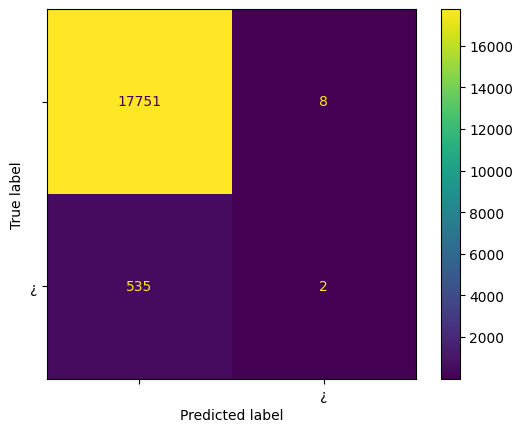

In [6]:
# draw confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()